Dataset Generation

- All Files have been looped through to get the step and end labels indexed at the corresponding indexes to assign the labels

- Folder path have to defined with the path where the person's data and the respective stepMixed files have to be stored.
- It will be saved to a csv file with a defined name by ourselves, i have used a generic name as i was creating multiple files of data .

In [ ]:
import pandas as pd
import os

# Folder path of the all the folders available of different persons
folder_path = '..\..\siva\data'

# Main dataframe to store the samples after looping through each person file alternatively
main_df = []

# Function to create the whole dataset with our inputs
def make_data(folder_path):
    # Just a counter for me to understand how many files will be processed by end
    i = 0
    for root,dirs, files in os.walk(folder_path):
        for file in files:
            # checking the file with the extension .csv
            if file.endswith('.csv'):
                    csv_path = os.path.join(root , file)
                    # checking the corresponding .stepMixed file for the respective .csv file
                    step_path = os.path.join(root, file[7:] + '.stepMixed')

                    # checking if the stepMixed file exists
                    if os.path.exists(step_path):
                        i += 1
                        # Reading the csv file into a dataframe
                        df = pd.read_csv(csv_path)
                        # Reading the stepMixed file into a dataframe
                        step = pd.read_csv(step_path,header = None)

                        df['STEP'] = '0'


                         # loop to delete the the first rows of the start index
#                         for start_removed in step.iloc[0,0:1]:
#                             #print(start_removed)
#                             for value in range(0,start_removed):
#                                 #print(value)
#                                 df.at[value, 'STEP'] = 'start_Remove'
#                         for end_removed in step.iloc[-1 ,1:]:
#                             #print(end_removed)
#                             #break
#                             for value in range(end_removed, len(df)):
#                                 df.at[value,'STEP'] = 'end_Remove'


                        # labelling of the signals starts here
                        for start in step[0]:
                            for start_index in range(start , start+10):
                                df.at[start_index,'STEP'] = 1 # start
                        for end in step[1]:
                            for end_index in range(end-10,end+1):
                                df.at[end_index ,'STEP'] = 1 # end

                        main_df.append(df)


make_data(folder_path)
combined_df = pd.concat(main_df, ignore_index=True)
# Dropping the Activity column as it is not being used in training the model
combined_df.drop(' Activity',axis=1 , inplace =True);
# Assigning the dataset to the below mentioned file name
combined_df.to_csv('siva_only_0_1_full_data.csv',index = False);

6
Epoch 1/10, Train Loss: 0.4895, Test Loss: 0.5362, Train Accuracy: 81.79%, Test Accuracy: 76.99%
Epoch 2/10, Train Loss: 0.4834, Test Loss: 0.5318, Train Accuracy: 82.31%, Test Accuracy: 77.28%
Epoch 3/10, Train Loss: 0.4806, Test Loss: 0.5370, Train Accuracy: 82.60%, Test Accuracy: 77.00%
Epoch 4/10, Train Loss: 0.4787, Test Loss: 0.5265, Train Accuracy: 82.78%, Test Accuracy: 77.80%
Epoch 5/10, Train Loss: 0.4775, Test Loss: 0.5113, Train Accuracy: 82.90%, Test Accuracy: 78.82%
Epoch 6/10, Train Loss: 0.4767, Test Loss: 0.5308, Train Accuracy: 82.97%, Test Accuracy: 77.39%
Epoch 7/10, Train Loss: 0.4756, Test Loss: 0.5357, Train Accuracy: 83.11%, Test Accuracy: 76.90%
Epoch 8/10, Train Loss: 0.4752, Test Loss: 0.5340, Train Accuracy: 83.14%, Test Accuracy: 76.70%
Epoch 9/10, Train Loss: 0.4747, Test Loss: 0.5313, Train Accuracy: 83.20%, Test Accuracy: 77.27%
Epoch 10/10, Train Loss: 0.4742, Test Loss: 0.5264, Train Accuracy: 83.24%, Test Accuracy: 77.95%


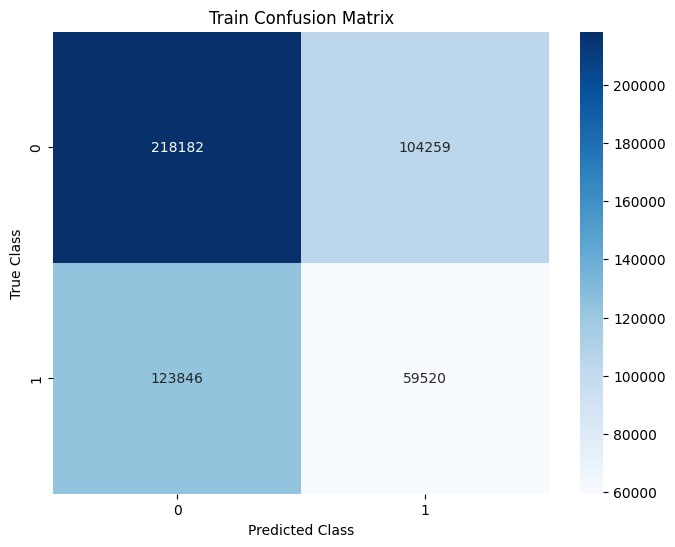

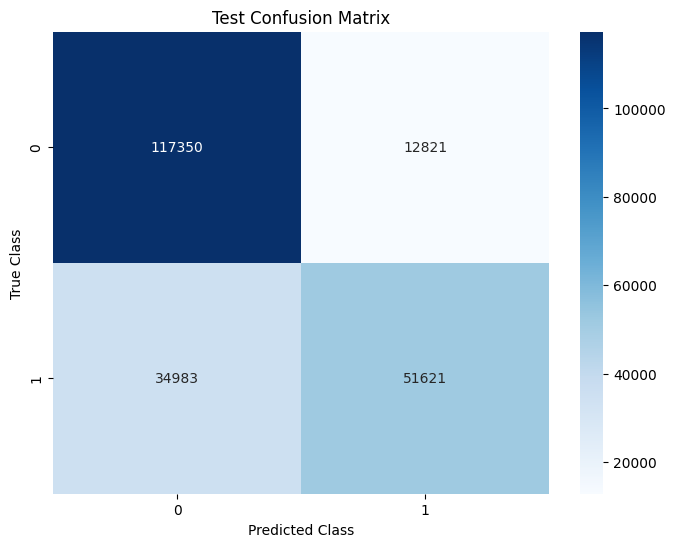

In [ ]:
# importing the libraries for training , plotting of results
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# warnings library to ignore the warning caused of the library dependencies and deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Creating a custom dataset class to create the dataset for our network with features and labels
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = torch.tensor(data.iloc[:, :-1].values.astype(np.float32))
        self.labels = torch.tensor(data.iloc[:, -1].values.astype(np.long))

    def __len__(self):
        # Return the length of the dataset (number of labels)
        return len(self.labels)

    def __getitem__(self, index):
        # Retrieve the features and label at the given index and return them
        return self.features[index], self.labels[index]

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        # Define the input layer of the neural network with the specified input size and the first hidden size
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        # Define the hidden layers of the neural network using a ModuleList
        # Each hidden layer is defined as a sequential combination of linear, ReLU activation, and batch normalization
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_sizes[i], hidden_sizes[i+1]),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_sizes[i+1])
            )
            for i in range(len(hidden_sizes)-1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass the input through the input layer
        x = self.input_layer(x)
        # Pass the input through each hidden layer in sequence
        for layer in self.hidden_layers:
            x = layer(x)
        # Pass the output of the last hidden layer through the output layer
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

data = pd.read_csv('/content/siva_only_0_1_full_data.csv')

# Split the dataset into training and testing data based on the train_ratio
# 70% training and 30% testing
train_ratio = 0.7
train_size = int(train_ratio * len(data))
train_data = data[:train_size]
test_data = data[train_size:]
# Create custom datasets for training and testing using the CustomDataset class
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)


# Set the batch size for training and testing data loaders
batch_size = 120
# Create data loaders for the training and test datasets
# The data will be loaded in batches with the specified batch size
# The training data will be shuffled during each epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = train_dataset.features.shape[1]
print(input_size)
# Define the sizes of the hidden layers in the neural network
hidden_sizes = [32,64,126,256,516]
output_size = 2
# Create an instance of the NeuralNetwork class with the specified input size, hidden sizes, and output size
model = NeuralNetwork(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs for training
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    model.train() # setting the model to training mode
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features #.to(device)
        batch_labels = batch_labels #.to(device)
        # Resetting the gradients of the optimizer
        optimizer.zero_grad()
        outputs = model(batch_features)
        # calculate the loss
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        # Update the training loss
        train_loss += loss.item() * batch_features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    # Calculate the average training loss and accuracy for the epoch
    train_loss /= len(train_dataset)
    train_accuracy = 100 * train_correct / train_total

    # Set the model to evaluation mode
    model.eval()
    # Initialize variables for tracking test loss, accuracy, and predictions
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_predicted = []
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features #.to(device)
            batch_labels = batch_labels #.to(device)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            test_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()
            test_predicted.extend(predicted.cpu().numpy())
        # Calculate the average test loss and accuracy
        test_loss /= len(test_dataset)
        test_accuracy = 100 * test_correct / test_total

    # Print the epoch number, train and test loss, train and test accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

# Compute confusion matrix for train set
train_true_labels = train_dataset.labels.numpy()
train_predicted = []
with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        train_predicted.extend(predicted.cpu().numpy())

import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix for the train set using true labels and predicted labels
train_true_labels = train_dataset.labels.numpy()
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted)

# Visualize train confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Compute confusion matrix for test set
test_true_labels = test_dataset.labels.numpy()
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted)

# Visualize test confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()



Finding about MLP:

- The model is having the dataset with a very high imbalance in the labels of the start and end indexes.
- The model is able to predict well on 0's more when compared to 1's. The model is just trying to predict the majority class most of the times for 1 and i able to get good accuracy in the training phase of the network.
- The confusion matrix shows that network is able to generalize well on the test set of 30% of the total train dataset . It is able to distinguish well between 0's and 1's in the test dataset but fails to find the differences between them in the train data.
- Used Batch Normalization to regularize the model more and which in turn reduces the over fitting of the model on the data.
- Tried running the network for 50 epochs but the learning is not happening even after so many epochs and the train accuracy is surrounded at 82-84% with variations and the test is around 76-79% - when submitted the test data results it gave 47% accuracy in the unseen data in competition
- Let's use different learning rates , epochs , Activation Functions , hidden Dimensions to see how the MLP would work on this kind of dataset with high imbalance of the labels and the nature of the data with an implicit sequential nature in the data samples .

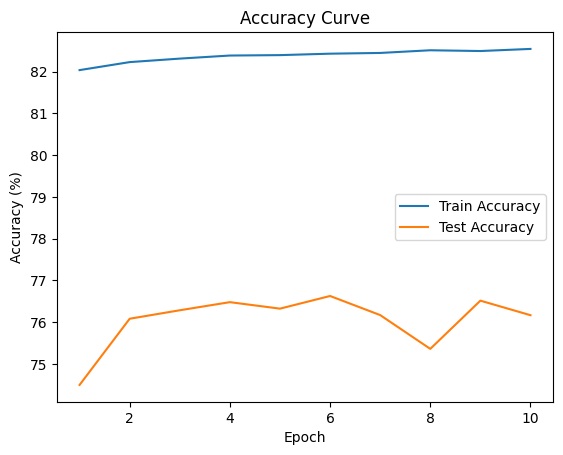

In [ ]:
train_accuracies = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
    model.train()

    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
# Plotting the train and test accuracies for 10 epochs
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


The above graph show that after 10 epochs the model is able to get to an accuracy of around 76.5 % on the test set and there is clear differences in the accuracies of the train accuracy and test accuracy by a maximum of 6-8% overall all the time.

# Training of Network with different Learning Rates

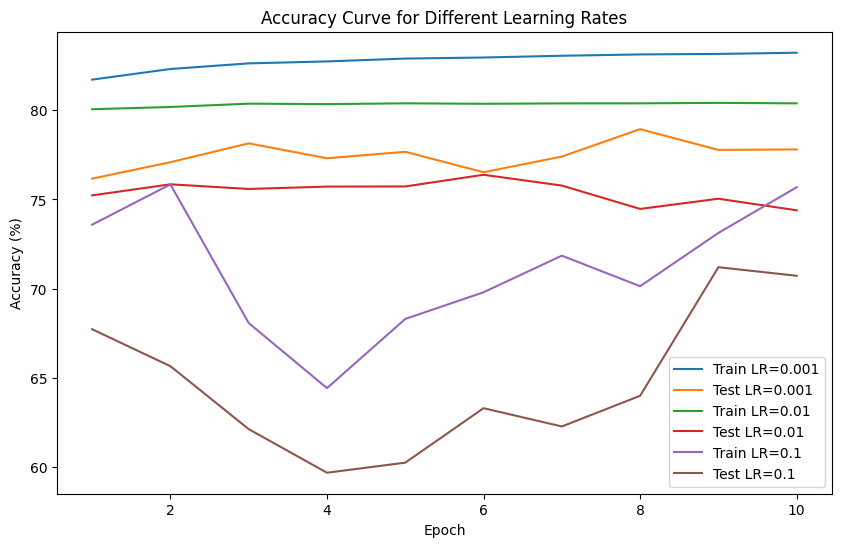

In [ ]:
# Define the learning rates to test the network
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 10

train_accuracies = []
test_accuracies = []

# Looping through the learning rates to calculate the train and test accuracies
for lr in learning_rates:
    model = NeuralNetwork(input_size, hidden_sizes, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc = []
    test_acc = []
    # iterating the number of epochs for each learning rate
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        model.train()

        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        train_acc.append(train_accuracy)

        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_features)
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_labels.size(0)
                test_correct += (predicted == batch_labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        test_acc.append(test_accuracy)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting the accuracies for different learning rates
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, num_epochs + 1), train_accuracies[i], label=f'Train LR={lr}')
    plt.plot(range(1, num_epochs + 1), test_accuracies[i], label=f'Test LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve for Different Learning Rates')
plt.legend()
plt.show()


The above graph show the model train and test accuracies of the MLP model with different learning rates.

learning rate = 0.001
- The train accuracy is almost constant all the time starting from the first epoch of training with 81-83 % accuracy. The test accuracy is fluctuating between the values 76-78% accuracy .

learning rate = 0.01
- The training accuracy is almost 80% all time for all 10 epochs but we could see a slight variations in the testing accuracy after the 6th epoch and gradually lowering which shows that the model is overfitting more on the train set.

learning rate = 0.1

- The Training accuracy and testing accuracy have a lot of fluctuations in the accuracies because of the very high learning rate and the model is not able to get to the global minimum and because of the high learning rate the model cannot come to local minimum because it shoots of the point because of very large change in the weights .

MLP with the learning rate 0.001 showed good amount of accuracy in both training and test accuracies compared to the other learning rates.

# Training the network with different Hidden Sizes

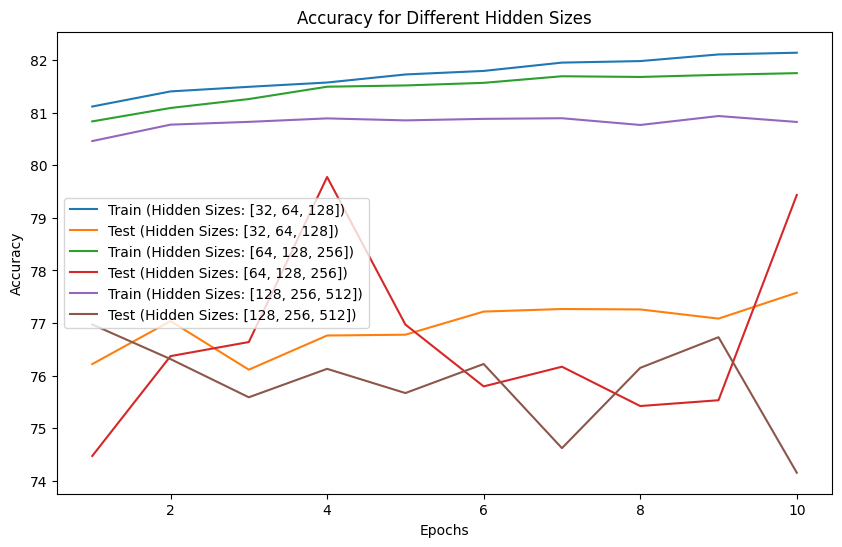

In [ ]:
# List of different hidden layer sizes to iterate over
hidden_sizes = [[32, 64, 128], [64, 128, 256], [128, 256, 512]]

num_epochs = 10
learning_rate = 0.01

# List to store train accuracies for each hidden size
train_accuracies = []
# List to store test accuracies for each hidden size
test_accuracies = []

for hidden_size in hidden_sizes:
    # Create a new model with the current hidden size configuration
    model = NeuralNetwork(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Calculate the average train loss
        train_loss /= len(train_dataset)
        # Calculate the train accuracy
        train_accuracy = 100 * train_correct / train_total

        # Set the model to evaluation mode
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                outputs = model(batch_features)
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_labels.size(0)
                test_correct += (predicted == batch_labels).sum().item()

        test_accuracy = 100 * test_correct / test_total

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

        #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    train_accuracies.append(train_accuracy_history)
    test_accuracies.append(test_accuracy_history)

# Plotting the accuracy for different hidden sizes
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs+1)

for i, hidden_size in enumerate(hidden_sizes):
    plt.plot(epochs, train_accuracies[i], label=f'Train (Hidden Sizes: {hidden_size})')
    plt.plot(epochs, test_accuracies[i], label=f'Test (Hidden Sizes: {hidden_size})')

plt.title('Accuracy for Different Hidden Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


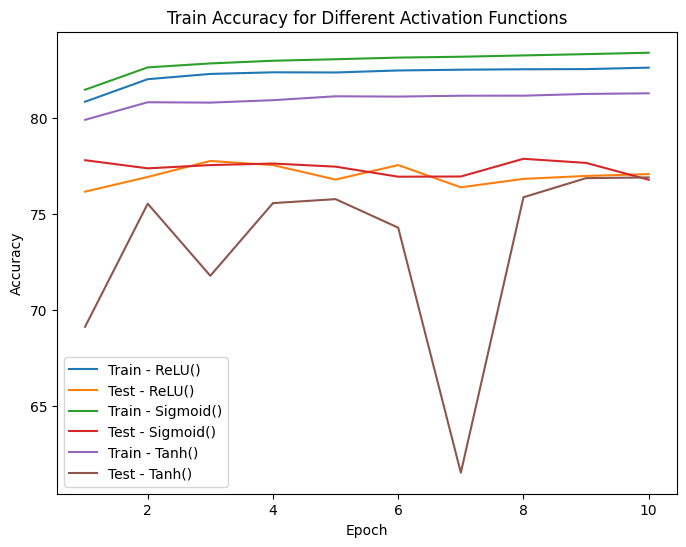

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = torch.tensor(data.iloc[:, :-1].values.astype(np.float32))
        self.labels = torch.tensor(data.iloc[:, -1].values.astype(np.long))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(NeuralNetwork, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

data = pd.read_csv('/content/siva_only_0_1_full_data.csv')

train_ratio = 0.7
train_size = int(train_ratio * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

batch_size = 120
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = train_dataset.features.shape[1]
hidden_size = 256
output_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
activations = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]

num_epochs = 10
learning_rate = 0.01

train_accuracies = []
test_accuracies = []

for activation in activations:
    model = NeuralNetwork(input_size, hidden_size, output_size, activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        train_loss /= len(train_dataset)
        train_accuracy = 100 * train_correct / train_total

        model.eval()
        test_correct = 0
        test_total = 0
        test_loss = 0.0

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                test_loss += loss.item() * batch_features.size(0)

                _, predicted = torch.max(outputs.data, 1)

                test_total += batch_labels.size(0)
                test_correct += (predicted == batch_labels).sum().item()

        test_loss /= len(test_dataset)
        test_accuracy = 100 * test_correct / test_total

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

    train_accuracies.append(train_accuracy_history)
    test_accuracies.append(test_accuracy_history)

# Plotting train accuracies
plt.figure(figsize=(8, 6))
for i, activation in enumerate(activations):
    plt.plot(range(1, num_epochs + 1), train_accuracies[i], label='Train - ' + str(activation))
    plt.plot(range(1, num_epochs + 1), test_accuracies[i], label='Test - ' + str(activation))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy for Different Activation Functions')
plt.legend()
plt.show()


MLP with different activation Functions

- ReLU and Sigmoid showed almost same kind of accuracies with around 1% difference in both the train and test accuracies with the above activation functions.

- Tanh showed less train accuracy when compared to the other two activation functions but the the test accuracy has reduced very drastically for different epochs .



with MLP among our submissions, the accuracy score that we got is 49% on the test set in kaggle